# Ejercicio de clasificación

### 1. Visualización de clasificador de una dimensión

Primero hacemos algunos experimentos con los datos simulados de nuestro ejemplo de las notas.

In [1]:
import pandas as pd
import numpy as np
from plotnine import *
from plotnine.labels import xlab, ylab

In [22]:
def p_1(x):
  # probabilidades para generar datos  
  if x < 0.15:
    p = 0.95
  else:
    p =  0.95 - 0.7 * (x - 0.15)
  return p

dat_mod = pd.DataFrame({"x":np.linspace(0, 1, 100)})
dat_mod["p_1"] = [p_1(x) for x in dat_mod.x] 

def simular_impago(n = 500):
  # simula datos como en el ejemplo
  x = np.minimum(np.random.exponential(40.0 / 100.0, n), 1)
  probs = [p_1(a) for a in x]
  g = np.random.binomial(1, probs, n)
  return pd.DataFrame({"x":x, "p_1":probs, "g":g})
np.random.seed(4223)
dat_ent  = simular_impago(50)
# tomamos una muestra de prueba grande para no considerar
# error de estimación
dat_prueba = simular_impago(10000)

Ajusta regresión logística

In [23]:
from sklearn.linear_model import LogisticRegression
X = dat_ent[["x"]]
y = dat_ent["g"]
reg_log_ajustada = LogisticRegression(penalty='none', solver="newton-cg").fit(X, y)
print("Ordenada: ", reg_log_ajustada.intercept_)
print("Coeficientes: ", reg_log_ajustada.coef_)

Ordenada:  [2.57286214]
Coeficientes:  [[-4.57235438]]


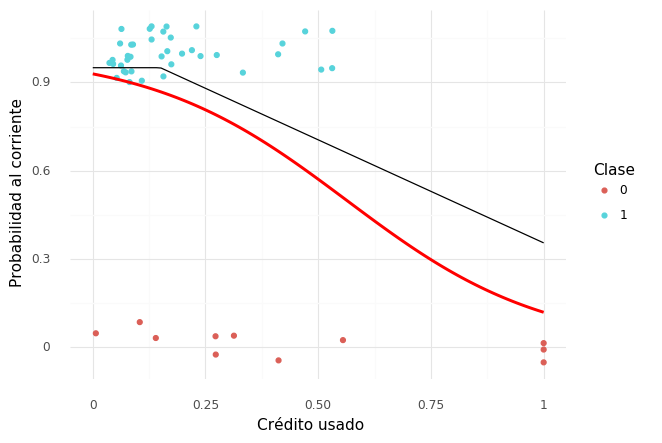

<ggplot: (-9223363271987899297)>

In [24]:
graf_data = pd.DataFrame({"x":np.linspace(0, 1, 100)})
probas = reg_log_ajustada.predict_proba(graf_data)
graf_data["p_1"] = probas[:, 1]
(ggplot(dat_ent, aes(x = "x")) 
  + geom_jitter(aes(colour = "factor(g)", y = "g"), width=0.0, height=0.1)
  + ylab("") + labs(color = "Clase") + theme_minimal()
  + geom_line(aes(y = "p_1"), data = dat_mod) 
  + geom_line(aes(y = "p_1"), data = graf_data, color = 'red', size = 1.2) 
  + ylab('Probabilidad al corriente') + xlab('Crédito usado'))

Puedes practicar aquí para ver cómo se ven los modelos logísticos con distintos parámetros:

   curva    a    b  key
0      1  0.0 -0.2    1
1      2  0.8  0.6    1
2      3  0.5  1.0    1


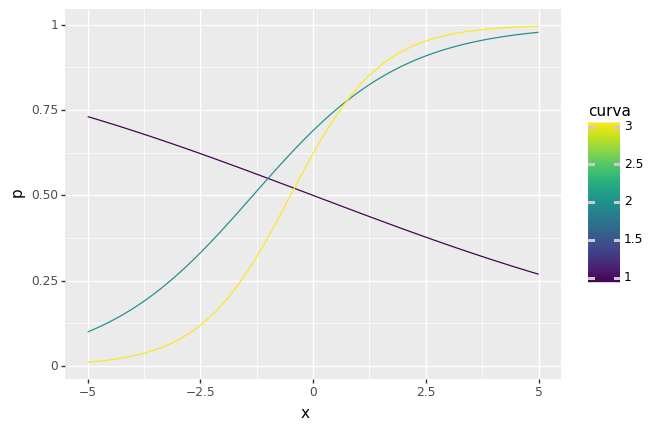

<ggplot: (8764865206143)>

In [25]:
parametros = pd.DataFrame({"curva":[1,2,3], "a":[0, 0.8, 0.5], "b":[-0.2, 0.6, 1.0], "key": 1})
print(parametros)
def h(x):
    return 1/(1 + np.exp(-x))
x_df = pd.DataFrame({"x":np.linspace(-5, 5, 100), "key": 1})
curvas_df = pd.merge(parametros, x_df)
def calcular_h(renglon):
    return h(renglon['a'] + renglon['b']*renglon['x'])  
curvas_df["p"] = curvas_df.apply(calcular_h, axis = 1)
(ggplot(curvas_df, aes(x = "x", y = "p", colour="curva", group="curva")) + geom_line())

#### Evaluación del modelo

Podemos obtener distintas métricas de evaluación para nuestro modelo basado en las probabilidades

In [30]:
from sklearn.metrics import brier_score_loss
from sklearn.metrics import log_loss
probas  = reg_log_ajustada.predict_proba(dat_prueba[["x"]])
log_perdida = log_loss(dat_prueba[["g"]], probas[:, 1])
brier_perdida = brier_score_loss(dat_prueba[["g"]], probas[:, 1])
log_perdida.round(3)

0.465

In [31]:
brier_perdida.round(3)

0.149

### 2. Ejemplo de clasificador de diabetes

Consideramos predecir presencia de diabetes según covariables como numero de embarazos, niveles de glucosa, presión arterial, grueso de piel, indice de masa corporal, factores hereditarios y edad.

In [32]:
diabetes_ent = pd.read_csv('../datos/diabetes_entrena.csv')
diabetes_pr = pd.read_csv('../datos/diabetes_prueba.csv')
variables = diabetes_ent.columns.tolist()[1:7]
print(variables)
def preprocesar(df, seleccionar = []):
    df_2 = df.copy()
    y = np.where(df["type"]=="Yes", 1, 0)
    df_2 = df_2.drop(columns = ["type"])[seleccionar]
    return df_2, y


['glu', 'bp', 'skin', 'bmi', 'ped', 'age']


#### Construye un modelo solo usando  índice de masa corporal y evalúalo

In [33]:
X_ent, y_ent = preprocesar(diabetes_ent, ['bmi'])
X_pr, y_pr = preprocesar(diabetes_pr, ['bmi'])
X_ent

,bmi
0,30.2
1,25.1
2,35.8
3,47.9
4,26.4
...,...
195,25.4
196,38.5
197,39.4
198,33.3


In [10]:
reg_diabetes_1 = LogisticRegression(penalty='none', solver="newton-cg").fit(X_ent, y_ent)
probas  = reg_diabetes_1.predict_proba(X_pr)
log_perdida = log_loss(y_pr, probas[:, 1])
brier_perdida = brier_score_loss(y_pr, probas[:, 1])
print(log_perdida.round(3))
print(brier_perdida.round(3))

0.585
0.201


Examina los coeficientes

In [34]:
pd.DataFrame({"coefs":reg_diabetes_1.coef_[0,:], "variable":X_ent.columns})

,coefs,variable
0,0.104819,bmi


#### Construye un modelo usando todas las variables y evalúalo

In [35]:
X_ent, y_ent = preprocesar(diabetes_ent, variables)
X_pr, y_pr = preprocesar(diabetes_pr, variables)
reg_diabetes_todas = LogisticRegression(penalty='none', solver="newton-cg").fit(X_ent, y_ent)
probas  = reg_diabetes_todas.predict_proba(X_pr)
log_perdida = log_loss(y_pr, probas[:, 1])
brier_perdida = brier_score_loss(y_pr, probas[:, 1])
print(log_perdida.round(3))
print(brier_perdida.round(3))

0.448
0.141


Examina los coeficientes

In [36]:
pd.DataFrame({"coefs":reg_diabetes_todas.coef_[0,:], "variable":X_ent.columns})

,coefs,variable
0,0.031585,glu
1,-0.004920,bp
2,-0.002388,skin
3,0.081607,bmi
4,1.730824,ped
5,0.060686,age


In [37]:
X_ent.corr().round(2)

,glu,bp,skin,bmi,ped,age
glu,1.00,0.27,0.22,0.22,0.06,0.34
bp,0.27,1.00,0.26,0.24,-0.05,0.39
skin,0.22,0.26,1.00,0.66,0.10,0.25
bmi,0.22,0.24,0.66,1.00,0.19,0.13
ped,0.06,-0.05,0.10,0.19,1.00,-0.07
age,0.34,0.39,0.25,0.13,-0.07,1.00
